# Data Scientist Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the first project of the Data Scientist Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

** HINT: ** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [67]:
# TODO: Total number of records
n_records = data.shape[0]

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = data[data['income'] == '>50K'].shape[0]

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = data[data['income'] == '<=50K'].shape[0]

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k/n_records

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent*100))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

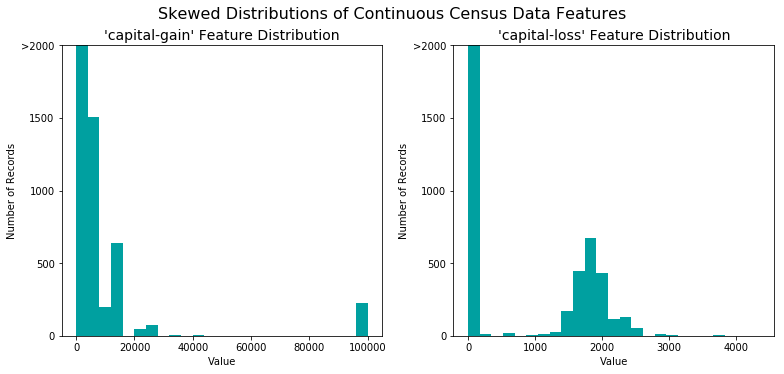

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

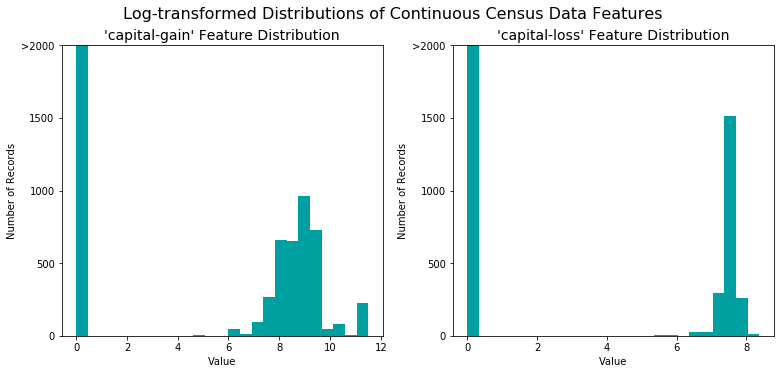

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

| -  | someFeature |      -              | someFeature_A | someFeature_B | someFeature_C |
| -  |  |                    | || |
| 0 |  B  | - | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  | - | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# TODO: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(data=features_log_minmax_transform)

# TODO: Encode the 'income_raw' data to numerical values
income = pd.Series(np.where(income_raw=='>50K', 1, 0))

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
# print encoded

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [7]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

** Please note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

** HINT: ** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [8]:

TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# TODO: Calculate accuracy, precision and recall
accuracy = (TP+TN)/income.shape[0]
recall = TP / (TP+FN)
precision = TP/(TP+FP)

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1+0.5**2)*(precision*recall)/(0.5**2*precision+recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

** HINT: **

Structure your answer in the same format as above^, with 4 parts for each of the three models you pick. Please include references with your answer.

**Answer:**

### AdaBoost

**Real-world application:** An evolutionary form of AdaBoost has been used for [detecting traffic lights](http://www.maia.ub.es/~sergio/files/Transport09.pdf).

**Strenghts:**
- Automatically handles missing values
- No need to transform any variable
- It doesn’t overfit easily
- Few parameters to tweak
- It can leverage many different weak-learners

**Weaknesses:**
- Sensitive to noisy data and outliers
- Never the best in class predictions

**Justification**
- Adaboost is the one of most popular boosting algorithms for binary classification and I would like to explore it for this exercise.

### Random Forest

**Real-world application:** Random Forests have been used for [detection and prediction of Alzheimer's disease](https://www.sciencedirect.com/science/article/pii/S2213158214001326).

**Strenghts:**
- Can work in parallel
- Seldom overfits
- Automatically handles missing values
- No need to transform any variable
- No need to tweak parameters

**Weaknesses:**
- Difficult to interpret
- Weaker on regression when estimating values at the extremities of the distribution of response values

**Justification**
- Random Forests are easy to implement and widely used. Also they deal well with categorical data which is abundant in our dataset.

### Logistic Regression

**Real-world application:** Logistic regression hast been used to [evaluate the hazard of landslides at Penang, Malaysia](https://www.researchgate.net/publication/209803049_Application_of_logistic_regression_model_and_its_validation_for_landslide_susceptibility_mapping_using_GIS_and_remote_sensing_data_journals).

**Strenghts:**
- Simple to understand and explain
- It seldom overfits
- Using L1 & L2 regularization is effective in feature selection
- Fast to train
- Easy to train on big data thanks to its stochastic version

**Weaknesses:**
- Difficult to fit to nonlinear functions
- Can suffer from outliers

**Justification**
- As Logistic Regression is a popular model for binary classification which is simple I would like to include it as a benchmark to the more complex models.

---

Reference: https://www.dummies.com/programming/big-data/data-science/machine-learning-dummies-cheat-sheet/

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [21]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test,predictions_test,beta=0.5)
    
    # OPTIONAL: Compute Precision on the the first 300 training samples
    results['p_train'] = precision_score(y_train[:300], predictions_train)
        
    # TODO: Compute F-score on the test set which is y_test
    results['p_test'] = precision_score(y_test,predictions_test)

    # OPTIONAL: Compute Recall on the the first 300 training samples
    results['r_train'] = recall_score(y_train[:300], predictions_train)
        
    # TODO: Compute Recall on the test set which is y_test
    results['r_test'] = recall_score(y_test,predictions_test)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.


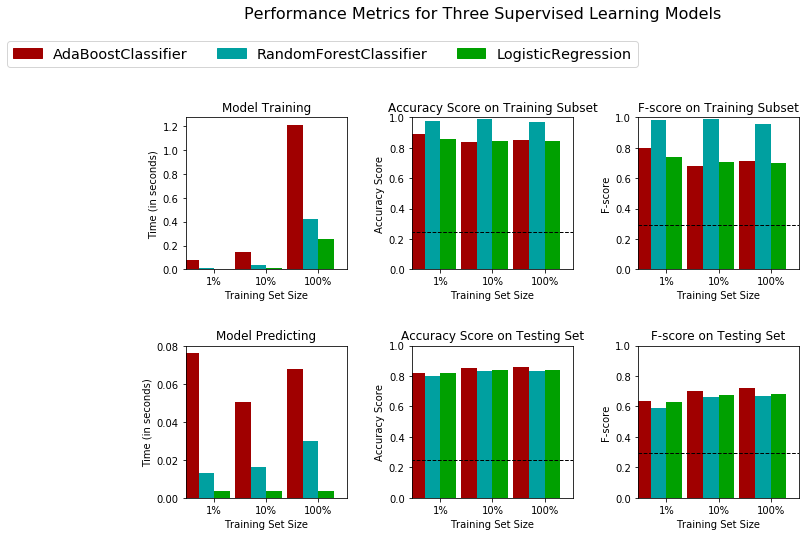

In [22]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# TODO: Initialize the three models
clf_A = AdaBoostClassifier()
clf_B = RandomForestClassifier()
clf_C = LogisticRegression()

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100 * 0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [24]:
import pprint
print(type(results))
pprint.pprint(results)

<class 'dict'>
{'AdaBoostClassifier': {0: {'acc_test': 0.8206744057490326,
                            'acc_train': 0.8933333333333333,
                            'f_test': 0.6327567673214111,
                            'f_train': 0.8012820512820513,
                            'p_test': 0.645241654210264,
                            'p_train': 0.8333333333333334,
                            'pred_time': 0.07661819458007812,
                            'r_test': 0.5873015873015873,
                            'r_train': 0.6944444444444444,
                            'train_time': 0.0804131031036377},
                        1: {'acc_test': 0.849861802100608,
                            'acc_train': 0.84,
                            'f_test': 0.7018820838099199,
                            'f_train': 0.6801470588235293,
                            'p_test': 0.7285483000539665,
                            'p_train': 0.74,
                            'pred_time': 0.0504450798034668,
  

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

** HINT: ** 
Look at the graph at the bottom left from the cell above(the visualization created by `vs.evaluate(results, accuracy, fscore)`) and check the F score for the testing set when 100% of the training set is used. Which model has the highest score? Your answer should include discussion of the:
* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

**Answer:**

Based on the results above, AdaBoost beats Logistic Regression and Random Forest both in F score (0.724 vs. 0.683 and 0.672 respectively) for the test set using 100% of the samples. Although the training and predicting time is higher for AdaBoost it is still in an acceptable range. All models work well for binary data so all of them are suitable for our data set. I would recommend AdaBoost based on the slightly higher F score.

### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

** HINT: **

When explaining your model, if using external resources please include all citations.

**Answer:**

AdaBoost uses a combination of "weak learners" which are simple classification algorithms and are hardly yielding better results than random guessing. The model works in iterations. After the first classification some of the data points will be correctly classified and some will not. In each iteration the weak learner is told to put more weight on correctly classifying the misclassified data points resulting from the previous iteration. After the final iteration the weak learners are combined and each data point is classified by a weighted majority vote of all weak learners. The picture below illustrates the process.

![test](adaboost.png)

_Reference: "Sebastian Raschka - Python Machine Learning, 2nd edition - p. 399"_

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [12]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Initialize the classifier
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'n_estimators': [50, 100, 150], 
              'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
              'base_estimator__min_samples_split' : np.arange(2, 10, 2),
              'base_estimator__max_depth' : np.arange(1, 5, 1)
             }

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=scorer, verbose=100)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train,y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

Fitting 3 folds for each of 240 candidates, totalling 720 fits
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=50 


/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=50, score=0.468653 -   1.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=50 
[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=50, score=0.322621 -   0.9s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=50 
[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=50, score=0.455119 -   0.9s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=100 
[CV]  base_estimator__max_depth=1, b

[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.1, n_estimators=150, score=0.727952 -   2.7s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   48.9s remaining:    0.0s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=50 
[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=50, score=0.726577 -   0.8s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:   49.8s remaining:    0.0s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=50 
[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=50, score=0.724720 -   0.8s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:   50.6s remaining:    0.0s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=50 
[CV]  base_estimator__max_depth=1, base_es

[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=4, learning_rate=0.01, n_estimators=150, score=0.470077 -   2.4s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:  1.5min remaining:    0.0s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=4, learning_rate=0.01, n_estimators=150 
[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=4, learning_rate=0.01, n_estimators=150, score=0.455119 -   2.3s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  1.6min remaining:    0.0s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=4, learning_rate=0.05, n_estimators=50 
[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=4, learning_rate=0.05, n_estimators=50, score=0.696239 -   0.8s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:  1.6min remaining:    0.0s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=4, learning_rate=0.05, n_estimators=50 
[CV]  base_estimator__max_depth=1,

[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=4, learning_rate=0.5, n_estimators=150, score=0.739704 -   2.4s
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:  2.2min remaining:    0.0s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=4, learning_rate=0.5, n_estimators=150 
[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=4, learning_rate=0.5, n_estimators=150, score=0.736746 -   2.4s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  2.2min remaining:    0.0s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=4, learning_rate=0.5, n_estimators=150 
[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=4, learning_rate=0.5, n_estimators=150, score=0.735023 -   2.3s
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  2.3min remaining:    0.0s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=4, learning_rate=1, n_estimators=50 
[CV]  base_estimator__max_depth=1, base_

[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=6, learning_rate=0.05, n_estimators=150, score=0.720056 -   2.4s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=6, learning_rate=0.05, n_estimators=150 
[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=6, learning_rate=0.05, n_estimators=150, score=0.724865 -   2.6s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=6, learning_rate=0.1, n_estimators=50 
[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=6, learning_rate=0.1, n_estimators=50, score=0.705987 -   0.8s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=6, learning_rate=0.1, n_estimators=50 
[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=6, learning_rate=0.1, n_estimators=50, score=0.711205 -   0.9s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=6, learning_rate=0.1, n_estimators=50 
[CV]  base_estimator__max_depth=1, bas

[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=8, learning_rate=0.01, n_estimators=150, score=0.468006 -   2.4s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=8, learning_rate=0.01, n_estimators=150 
[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=8, learning_rate=0.01, n_estimators=150, score=0.470077 -   2.3s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=8, learning_rate=0.01, n_estimators=150 
[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=8, learning_rate=0.01, n_estimators=150, score=0.455119 -   2.3s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=8, learning_rate=0.05, n_estimators=50 
[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=8, learning_rate=0.05, n_estimators=50, score=0.696239 -   0.8s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=8, learning_rate=0.05, n_estimators=50 
[CV]  base_estimator__max_depth

[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=8, learning_rate=1, n_estimators=100, score=0.740056 -   1.5s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=8, learning_rate=1, n_estimators=150 
[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=8, learning_rate=1, n_estimators=150, score=0.744631 -   2.3s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=8, learning_rate=1, n_estimators=150 
[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=8, learning_rate=1, n_estimators=150, score=0.733139 -   2.3s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=8, learning_rate=1, n_estimators=150 
[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=8, learning_rate=1, n_estimators=150, score=0.744656 -   2.5s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=50 
[CV]  base_estimator__max_depth=2, base_estimator_

[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=100, score=0.754439 -   2.5s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=100 
[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=100, score=0.761067 -   2.5s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=150 
[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=150, score=0.753088 -   3.8s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=150 
[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=150, score=0.752536 -   3.8s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=150 
[CV]  base_estimator__max_depth=2, b

[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=4, learning_rate=0.1, n_estimators=100, score=0.741256 -   2.6s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=4, learning_rate=0.1, n_estimators=100 
[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=4, learning_rate=0.1, n_estimators=100, score=0.742819 -   2.6s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=4, learning_rate=0.1, n_estimators=100 
[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=4, learning_rate=0.1, n_estimators=100, score=0.749681 -   2.5s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=4, learning_rate=0.1, n_estimators=150 
[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=4, learning_rate=0.1, n_estimators=150, score=0.745077 -   3.8s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=4, learning_rate=0.1, n_estimators=150 
[CV]  base_estimator__max_depth=2, b

[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=6, learning_rate=0.05, n_estimators=50, score=0.713470 -   1.3s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=6, learning_rate=0.05, n_estimators=100 
[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=6, learning_rate=0.05, n_estimators=100, score=0.728391 -   2.6s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=6, learning_rate=0.05, n_estimators=100 
[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=6, learning_rate=0.05, n_estimators=100, score=0.729917 -   2.6s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=6, learning_rate=0.05, n_estimators=100 
[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=6, learning_rate=0.05, n_estimators=100, score=0.734450 -   2.6s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=6, learning_rate=0.05, n_estimators=150 
[CV]  base_estimator__max_dep

[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=8, learning_rate=0.01, n_estimators=50, score=0.695494 -   1.4s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=8, learning_rate=0.01, n_estimators=50 
[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=8, learning_rate=0.01, n_estimators=50, score=0.697902 -   1.5s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=8, learning_rate=0.01, n_estimators=100 
[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=8, learning_rate=0.01, n_estimators=100, score=0.701762 -   2.8s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=8, learning_rate=0.01, n_estimators=100 
[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=8, learning_rate=0.01, n_estimators=100, score=0.701461 -   2.8s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=8, learning_rate=0.01, n_estimators=100 
[CV]  base_estimator__max_depth

[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=8, learning_rate=0.5, n_estimators=150, score=0.758221 -   3.8s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=8, learning_rate=1, n_estimators=50 
[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=8, learning_rate=1, n_estimators=50, score=0.738371 -   1.3s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=8, learning_rate=1, n_estimators=50 
[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=8, learning_rate=1, n_estimators=50, score=0.742001 -   1.3s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=8, learning_rate=1, n_estimators=50 
[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=8, learning_rate=1, n_estimators=50, score=0.751504 -   1.3s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=8, learning_rate=1, n_estimators=100 
[CV]  base_estimator__max_depth=2, base_estimator__min_s

[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=2, learning_rate=0.1, n_estimators=150, score=0.748252 -   5.3s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=2, learning_rate=0.1, n_estimators=150 
[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=2, learning_rate=0.1, n_estimators=150, score=0.757337 -   5.4s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=50 
[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=50, score=0.751170 -   1.8s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=50 
[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=50, score=0.750777 -   1.9s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=50 
[CV]  base_estimator__max_depth=3, base_e

[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=4, learning_rate=0.05, n_estimators=150, score=0.753946 -   5.4s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=4, learning_rate=0.05, n_estimators=150 
[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=4, learning_rate=0.05, n_estimators=150, score=0.751898 -   5.5s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=4, learning_rate=0.05, n_estimators=150 
[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=4, learning_rate=0.05, n_estimators=150, score=0.760060 -   5.4s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=4, learning_rate=0.1, n_estimators=50 
[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=4, learning_rate=0.1, n_estimators=50, score=0.749073 -   1.9s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=4, learning_rate=0.1, n_estimators=50 
[CV]  base_estimator__max_depth=3,

[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=6, learning_rate=0.01, n_estimators=100, score=0.702768 -   3.6s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=6, learning_rate=0.01, n_estimators=150 
[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=6, learning_rate=0.01, n_estimators=150, score=0.710184 -   5.4s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=6, learning_rate=0.01, n_estimators=150 
[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=6, learning_rate=0.01, n_estimators=150, score=0.715117 -   5.5s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=6, learning_rate=0.01, n_estimators=150 
[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=6, learning_rate=0.01, n_estimators=150, score=0.715614 -   5.5s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=6, learning_rate=0.05, n_estimators=50 
[CV]  base_estimator__max_dep

[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=6, learning_rate=1, n_estimators=100, score=0.732844 -   3.5s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=6, learning_rate=1, n_estimators=100 
[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=6, learning_rate=1, n_estimators=100, score=0.730789 -   3.6s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=6, learning_rate=1, n_estimators=150 
[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=6, learning_rate=1, n_estimators=150, score=0.729144 -   5.3s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=6, learning_rate=1, n_estimators=150 
[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=6, learning_rate=1, n_estimators=150, score=0.726343 -   5.3s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=6, learning_rate=1, n_estimators=150 
[CV]  base_estimator__max_depth=3, base_estimator__m

[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=8, learning_rate=0.5, n_estimators=100, score=0.746623 -   3.6s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=8, learning_rate=0.5, n_estimators=100 
[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=8, learning_rate=0.5, n_estimators=100, score=0.747785 -   3.5s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=8, learning_rate=0.5, n_estimators=100 
[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=8, learning_rate=0.5, n_estimators=100, score=0.752229 -   3.6s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=8, learning_rate=0.5, n_estimators=150 
[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=8, learning_rate=0.5, n_estimators=150, score=0.743087 -   5.3s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=8, learning_rate=0.5, n_estimators=150 
[CV]  base_estimator__max_depth=3, b

[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=2, learning_rate=0.1, n_estimators=50, score=0.762172 -   2.4s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=2, learning_rate=0.1, n_estimators=100 
[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=2, learning_rate=0.1, n_estimators=100, score=0.755359 -   4.7s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=2, learning_rate=0.1, n_estimators=100 
[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=2, learning_rate=0.1, n_estimators=100, score=0.749788 -   4.6s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=2, learning_rate=0.1, n_estimators=100 
[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=2, learning_rate=0.1, n_estimators=100, score=0.756789 -   4.7s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=2, learning_rate=0.1, n_estimators=150 
[CV]  base_estimator__max_depth=4, ba

[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=4, learning_rate=0.05, n_estimators=50, score=0.738710 -   2.6s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=4, learning_rate=0.05, n_estimators=50 
[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=4, learning_rate=0.05, n_estimators=50, score=0.734188 -   2.4s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=4, learning_rate=0.05, n_estimators=100 
[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=4, learning_rate=0.05, n_estimators=100, score=0.757538 -   4.9s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=4, learning_rate=0.05, n_estimators=100 
[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=4, learning_rate=0.05, n_estimators=100, score=0.755602 -   4.8s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=4, learning_rate=0.05, n_estimators=100 
[CV]  base_estimator__max_depth

[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=6, learning_rate=0.01, n_estimators=50, score=0.709315 -   3.2s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=6, learning_rate=0.01, n_estimators=50 
[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=6, learning_rate=0.01, n_estimators=50, score=0.698706 -   2.6s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=6, learning_rate=0.01, n_estimators=50 
[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=6, learning_rate=0.01, n_estimators=50, score=0.708482 -   2.6s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=6, learning_rate=0.01, n_estimators=100 
[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=6, learning_rate=0.01, n_estimators=100, score=0.720936 -   5.2s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=6, learning_rate=0.01, n_estimators=100 
[CV]  base_estimator__max_depth=4

[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=6, learning_rate=0.5, n_estimators=150, score=0.724037 -   6.8s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=6, learning_rate=0.5, n_estimators=150 
[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=6, learning_rate=0.5, n_estimators=150, score=0.729143 -   6.8s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=6, learning_rate=1, n_estimators=50 
[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=6, learning_rate=1, n_estimators=50, score=0.727201 -   2.3s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=6, learning_rate=1, n_estimators=50 
[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=6, learning_rate=1, n_estimators=50, score=0.723842 -   2.3s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=6, learning_rate=1, n_estimators=50 
[CV]  base_estimator__max_depth=4, base_estimator__

[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=8, learning_rate=0.1, n_estimators=150, score=0.752003 -   6.8s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=8, learning_rate=0.1, n_estimators=150 
[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=8, learning_rate=0.1, n_estimators=150, score=0.749791 -   6.8s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=8, learning_rate=0.1, n_estimators=150 
[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=8, learning_rate=0.1, n_estimators=150, score=0.755936 -   6.8s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=8, learning_rate=0.5, n_estimators=50 
[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=8, learning_rate=0.5, n_estimators=50, score=0.747178 -   2.3s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=8, learning_rate=0.5, n_estimators=50 
[CV]  base_estimator__max_depth=4, base

In [25]:
# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Precision score on testing data: {:.4f}".format(precision_score(y_test, predictions)))
print("Recall score on testing data: {:.4f}".format(recall_score(y_test, predictions)))
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final precision on testing data: {:.4f}".format(precision_score(y_test, best_predictions)))
print("Final recall on testing data: {:.4f}".format(recall_score(y_test, best_predictions)))
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Precision score on testing data: 0.6708
Recall score on testing data: 0.6313
Accuracy score on testing data: 0.8346
F-score on testing data: 0.6625

Optimized Model
------
Final precision on testing data: 0.7935
Final recall on testing data: 0.6186
Final accuracy score on the testing data: 0.8678
Final F-score on the testing data: 0.7510


### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  

**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Naive Predictor | Unoptimized Model | Optimized Model |
| - | |  |  | 
| Accuracy Score | 0.2478 |        0.8346          |        0.8678         |
| F-score        | 0.2917 |          0.6625        |   0.7510|


**Answer:**

As expected we see a huge improvement by using any standard classification model - even if unoptimized - compared to the naive classifier. By optimizing our model of choice, AdaBoost, we were able to considerably increase both accuracy and F-score from 0.8346 to 0.8678 and from 0.6625 to 0.7510 respectively.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

**Answer:**

I believe the following features will play an important role in the model and would rank them the following way:

1. Capital Gain: Should have a strong influence on income if that captial movement is part of the person's income.
2. Capital Loss: Same as with Capital Gain.
3. Hours per week: I would expect a strong correlation between working hours per week and income.
4. Age: I believe there is a positive correlation between age and income. Older workforce is more experienced and will demand higher salaries due to increased living standards.
5. Workclass: I would expect workclass to have a strong influence, e.g. "never worked" or "without pay" to have a condiderably smaller income.

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

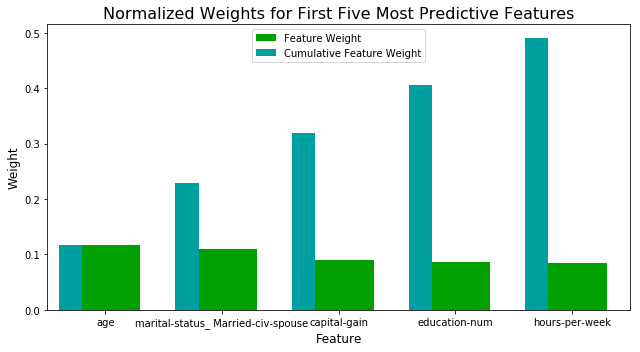

In [26]:
# TODO: Import a supervised learning model that has 'feature_importances_'


# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
#model = None

# TODO: Extract the feature importances using .feature_importances_ 
importances = best_clf.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

**Answer:**

Comparing my assumptions with the actual feature importance we can see that Capital Gain, Hours per Week and Age show up in both lists, albeit in a different order. I was wrong about Capital Loss and Workclass, instead marital-status and education-num seem to be more important. I assume that married men will earn more because they have to cater for a family, especially if the wife is not working, but a closer look at the data is necessary to confirm that. In the cell below I am counting number of individuals in each income bucket broken down by marital-status and sex. As we can see, it actually seems that married individuals are considerably more likely to earn more than 50k, both for men and women. Finally, number of years in education seems plausible as a factor as knowledge workers generally earn higher salaries.

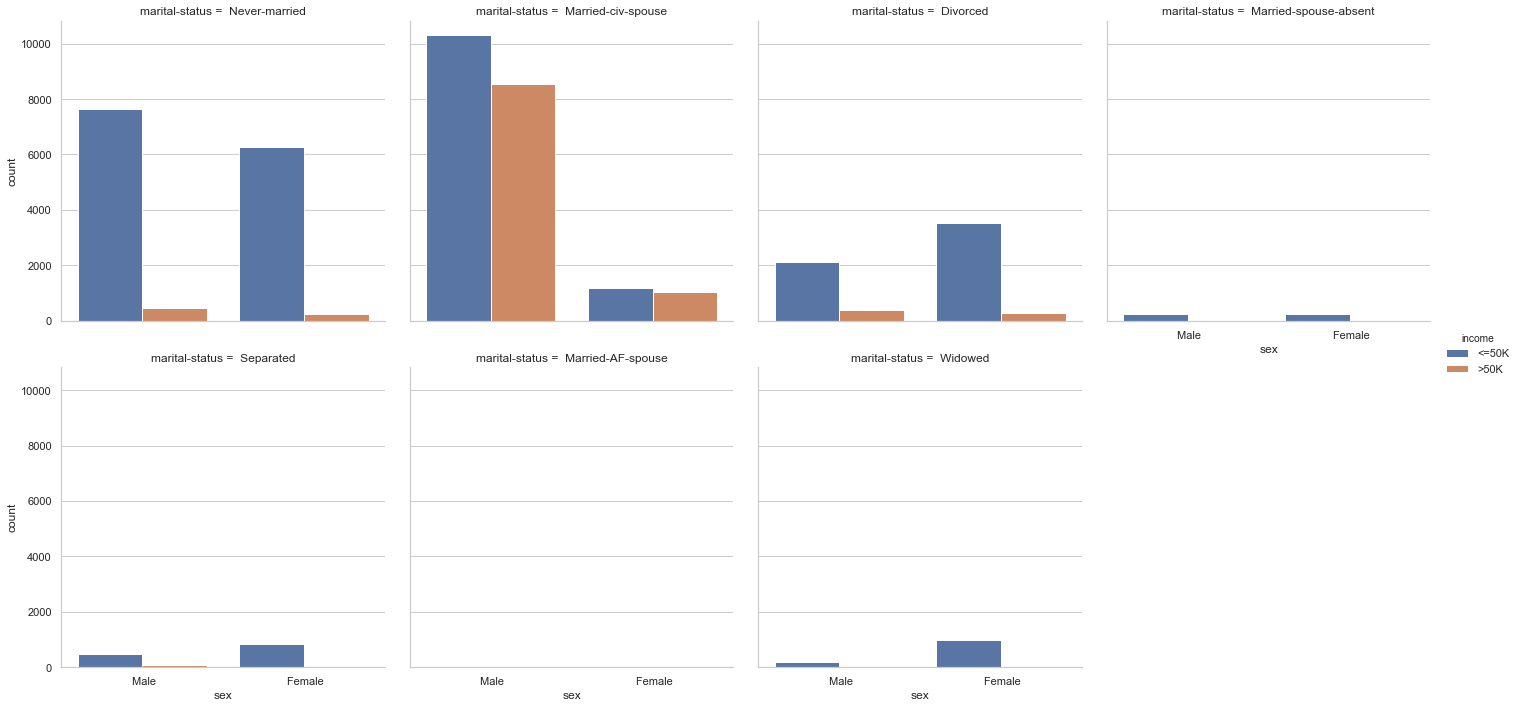

In [58]:
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
sns.catplot("sex", col='marital-status', data=data, hue='income', kind="count", col_wrap=4);

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [27]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8678
F-score on testing data: 0.7510

Final Model trained on reduced data
------
Accuracy on testing data: 0.8495
F-score on testing data: 0.7051


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

**Answer:**

We are losing 1.83 and 4.59 percentage points for accuracy and f-score respectively. If training time was a factor, we could consider training on the reduced data set but we would need to measure first how much time we would actually save. As the GridSearch for AdaBoost only took about 38 minutes to run on my MacBook Pro I would expect that this is not a limiting factor for CharityML.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In [47]:
print("Number of data points in test set:", best_predictions.shape[0])
print("Number of positively predicted data points in test set:", np.sum(best_predictions))
print("Ratio of positively predicted to overall:",np.sum(best_predictions)/best_predictions.shape[0])

Number of data points in test set: 9045
Number of positively predicted data points in test set: 1719
Ratio of positively predicted to overall: 0.1900497512437811


### Optional: Optimize for Precision

Let us look at the optimized AdaBoost model's results:

| Metric | Value | 
| -- | -- | 
| Final precision on testing data: |  0.7935
| Final recall on testing data: |  0.6186
| Final accuracy score on the testing data: |  0.8678
| Final F-score on the testing data: | 0.7510

The number of positively predicted outcomes out of all data points in the test set is 1719 out of 9045, or 19%. With a precision of 0.7935, CharityML would send out about `1719 * (1-0.7935) = 355` letters that have a low chance of yielding a donation from the recipient because the model incorrectly predicted these recipients to earn more than USD 50K per year. In general, that would be the case for 20% of all letters that CharityML would send out when using the optimized model.

However, CharityML stated in its goal that it wants to understand "which algorithm will provide the highest donation yield while also reducing the total number of letters being sent". Therefore I would like to suggest to add one additional step here which is training the model optimized on precision (Model B) and comparing it to the model optimized for F-Score (Model A). This is what I will do in the next cells.

In [31]:
# TODO: Make an fbeta_score scoring object using make_scorer()
scorer_p = make_scorer(precision_score)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj_p = GridSearchCV(clf, param_grid=parameters, scoring=scorer_p, verbose=10)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit_p = grid_obj_p.fit(X_train,y_train)

# Get the estimator
best_clf_p = grid_fit_p.best_estimator_

# Make predictions using the unoptimized and model
best_predictions_p = best_clf_p.predict(X_test)

Fitting 3 folds for each of 240 candidates, totalling 720 fits
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=50 
[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=50, score=0.989083 -   0.9s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=50, score=1.000000 -   0.8s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=50 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=50, score=0.986333 -   0.8s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=100 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.5s remaining:    0.0s


[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=100, score=0.989083 -   1.6s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=100 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.1s remaining:    0.0s


[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=100, score=0.993435 -   1.6s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=100 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.7s remaining:    0.0s


[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=100, score=0.986333 -   1.6s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=150 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    7.3s remaining:    0.0s


[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=150, score=0.989059 -   2.3s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=150 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    9.6s remaining:    0.0s


[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=150, score=0.993435 -   2.5s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=150 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   12.1s remaining:    0.0s


[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=150, score=0.986333 -   2.6s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.05, n_estimators=50 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   14.7s remaining:    0.0s


[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.05, n_estimators=50, score=0.781418 -   0.9s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.05, n_estimators=50 
[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.05, n_estimators=50, score=0.773927 -   0.9s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.05, n_estimators=50 
[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.05, n_estimators=50, score=0.791501 -   0.8s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.05, n_estimators=100 
[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.05, n_estimators=100, score=0.793991 -   1.6s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=0.05, n_estimators=100 
[CV]  base_estimator__max_depth=1

[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=2, learning_rate=1, n_estimators=150, score=0.780488 -   2.3s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=4, learning_rate=0.01, n_estimators=50 
[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=4, learning_rate=0.01, n_estimators=50, score=0.989083 -   0.8s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=4, learning_rate=0.01, n_estimators=50 
[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=4, learning_rate=0.01, n_estimators=50, score=1.000000 -   0.8s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=4, learning_rate=0.01, n_estimators=50 
[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=4, learning_rate=0.01, n_estimators=50, score=0.986333 -   0.8s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=4, learning_rate=0.01, n_estimators=100 
[CV]  base_estimator__max_depth=1, ba

[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=4, learning_rate=0.5, n_estimators=150, score=0.778620 -   2.3s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=4, learning_rate=0.5, n_estimators=150 
[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=4, learning_rate=0.5, n_estimators=150, score=0.772577 -   2.3s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=4, learning_rate=0.5, n_estimators=150 
[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=4, learning_rate=0.5, n_estimators=150, score=0.774398 -   2.3s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=4, learning_rate=1, n_estimators=50 
[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=4, learning_rate=1, n_estimators=50, score=0.767660 -   0.8s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=4, learning_rate=1, n_estimators=50 
[CV]  base_estimator__max_depth=1, base_estim

[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=6, learning_rate=0.1, n_estimators=100, score=0.806663 -   1.5s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=6, learning_rate=0.1, n_estimators=150 
[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=6, learning_rate=0.1, n_estimators=150, score=0.787011 -   2.3s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=6, learning_rate=0.1, n_estimators=150 
[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=6, learning_rate=0.1, n_estimators=150, score=0.780567 -   2.3s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=6, learning_rate=0.1, n_estimators=150 
[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=6, learning_rate=0.1, n_estimators=150, score=0.794560 -   2.3s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=6, learning_rate=0.5, n_estimators=50 
[CV]  base_estimator__max_depth=1, ba

[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=8, learning_rate=0.05, n_estimators=100, score=0.804372 -   1.6s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=8, learning_rate=0.05, n_estimators=100 
[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=8, learning_rate=0.05, n_estimators=100, score=0.814645 -   1.6s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=8, learning_rate=0.05, n_estimators=150 
[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=8, learning_rate=0.05, n_estimators=150, score=0.800828 -   2.4s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=8, learning_rate=0.05, n_estimators=150 
[CV]  base_estimator__max_depth=1, base_estimator__min_samples_split=8, learning_rate=0.05, n_estimators=150, score=0.802198 -   2.4s
[CV] base_estimator__max_depth=1, base_estimator__min_samples_split=8, learning_rate=0.05, n_estimators=150 
[CV]  base_estimator__max_de

[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=100, score=0.776417 -   2.6s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=100 
[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=100, score=0.778523 -   2.5s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=100 
[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=100, score=0.791309 -   2.6s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=150 
[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=150, score=0.781056 -   3.8s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=150 
[CV]  base_estimator__max_de

[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=2, learning_rate=1, n_estimators=50, score=0.767906 -   1.5s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=2, learning_rate=1, n_estimators=50 
[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=2, learning_rate=1, n_estimators=50, score=0.785306 -   1.5s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=2, learning_rate=1, n_estimators=100 
[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=2, learning_rate=1, n_estimators=100, score=0.767225 -   3.0s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=2, learning_rate=1, n_estimators=100 
[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=2, learning_rate=1, n_estimators=100, score=0.769709 -   2.7s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=2, learning_rate=1, n_estimators=100 
[CV]  base_estimator__max_depth=2, base_estimator__min_

[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=4, learning_rate=0.5, n_estimators=50, score=0.784461 -   1.3s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=4, learning_rate=0.5, n_estimators=50 
[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=4, learning_rate=0.5, n_estimators=50, score=0.784583 -   1.3s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=4, learning_rate=0.5, n_estimators=50 
[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=4, learning_rate=0.5, n_estimators=50, score=0.799224 -   1.3s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=4, learning_rate=0.5, n_estimators=100 
[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=4, learning_rate=0.5, n_estimators=100, score=0.781526 -   2.8s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=4, learning_rate=0.5, n_estimators=100 
[CV]  base_estimator__max_depth=2, base_e

[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=6, learning_rate=0.05, n_estimators=150, score=0.815482 -   4.1s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=6, learning_rate=0.1, n_estimators=50 
[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=6, learning_rate=0.1, n_estimators=50, score=0.800394 -   1.7s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=6, learning_rate=0.1, n_estimators=50 
[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=6, learning_rate=0.1, n_estimators=50, score=0.796913 -   1.6s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=6, learning_rate=0.1, n_estimators=50 
[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=6, learning_rate=0.1, n_estimators=50, score=0.806739 -   1.5s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=6, learning_rate=0.1, n_estimators=100 
[CV]  base_estimator__max_depth=2, base_e

[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=8, learning_rate=0.01, n_estimators=150, score=0.778468 -   3.9s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=8, learning_rate=0.01, n_estimators=150 
[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=8, learning_rate=0.01, n_estimators=150, score=0.793973 -   3.9s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=8, learning_rate=0.05, n_estimators=50 
[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=8, learning_rate=0.05, n_estimators=50, score=0.785388 -   1.5s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=8, learning_rate=0.05, n_estimators=50 
[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=8, learning_rate=0.05, n_estimators=50, score=0.791940 -   1.4s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=8, learning_rate=0.05, n_estimators=50 
[CV]  base_estimator__max_depth=2

[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=8, learning_rate=1, n_estimators=150, score=0.762145 -   3.9s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=8, learning_rate=1, n_estimators=150 
[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=8, learning_rate=1, n_estimators=150, score=0.765493 -   3.8s
[CV] base_estimator__max_depth=2, base_estimator__min_samples_split=8, learning_rate=1, n_estimators=150 
[CV]  base_estimator__max_depth=2, base_estimator__min_samples_split=8, learning_rate=1, n_estimators=150, score=0.774764 -   4.0s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=50 
[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=50, score=0.765054 -   2.0s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=50 
[CV]  base_estimator__max_depth=3, base_estima

[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=100, score=0.769261 -   3.5s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=100 
[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=100, score=0.785514 -   3.5s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=150 
[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=150, score=0.771362 -   5.4s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=150 
[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=150, score=0.767712 -   5.3s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=150 
[CV]  base_estimator__max_depth=3, b

[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=4, learning_rate=0.1, n_estimators=100, score=0.792944 -   3.5s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=4, learning_rate=0.1, n_estimators=100 
[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=4, learning_rate=0.1, n_estimators=100, score=0.783265 -   3.5s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=4, learning_rate=0.1, n_estimators=100 
[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=4, learning_rate=0.1, n_estimators=100, score=0.800940 -   3.5s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=4, learning_rate=0.1, n_estimators=150 
[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=4, learning_rate=0.1, n_estimators=150, score=0.783501 -   5.3s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=4, learning_rate=0.1, n_estimators=150 
[CV]  base_estimator__max_depth=3, b

[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=6, learning_rate=0.05, n_estimators=50, score=0.811943 -   1.9s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=6, learning_rate=0.05, n_estimators=100 
[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=6, learning_rate=0.05, n_estimators=100, score=0.799065 -   3.7s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=6, learning_rate=0.05, n_estimators=100 
[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=6, learning_rate=0.05, n_estimators=100, score=0.799630 -   3.7s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=6, learning_rate=0.05, n_estimators=100 
[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=6, learning_rate=0.05, n_estimators=100, score=0.814710 -   3.6s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=6, learning_rate=0.05, n_estimators=150 
[CV]  base_estimator__max_dep

[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=8, learning_rate=0.01, n_estimators=50, score=0.766201 -   1.8s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=8, learning_rate=0.01, n_estimators=50 
[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=8, learning_rate=0.01, n_estimators=50, score=0.775246 -   1.8s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=8, learning_rate=0.01, n_estimators=100 
[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=8, learning_rate=0.01, n_estimators=100, score=0.769715 -   3.5s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=8, learning_rate=0.01, n_estimators=100 
[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=8, learning_rate=0.01, n_estimators=100, score=0.768500 -   3.5s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=8, learning_rate=0.01, n_estimators=100 
[CV]  base_estimator__max_depth

[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=8, learning_rate=0.5, n_estimators=150, score=0.774603 -   5.2s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=8, learning_rate=1, n_estimators=50 
[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=8, learning_rate=1, n_estimators=50, score=0.758412 -   1.8s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=8, learning_rate=1, n_estimators=50 
[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=8, learning_rate=1, n_estimators=50, score=0.755263 -   1.8s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=8, learning_rate=1, n_estimators=50 
[CV]  base_estimator__max_depth=3, base_estimator__min_samples_split=8, learning_rate=1, n_estimators=50, score=0.771384 -   1.8s
[CV] base_estimator__max_depth=3, base_estimator__min_samples_split=8, learning_rate=1, n_estimators=100 
[CV]  base_estimator__max_depth=3, base_estimator__min_s

[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=2, learning_rate=0.1, n_estimators=150, score=0.773349 -   6.7s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=2, learning_rate=0.1, n_estimators=150 
[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=2, learning_rate=0.1, n_estimators=150, score=0.783152 -   7.6s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=50 
[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=50, score=0.766490 -   2.3s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=50 
[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=50, score=0.760671 -   2.2s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=50 
[CV]  base_estimator__max_depth=4, base_e

[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=4, learning_rate=0.05, n_estimators=150, score=0.792555 -   7.0s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=4, learning_rate=0.05, n_estimators=150 
[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=4, learning_rate=0.05, n_estimators=150, score=0.784465 -   6.9s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=4, learning_rate=0.05, n_estimators=150 
[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=4, learning_rate=0.05, n_estimators=150, score=0.805184 -   6.8s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=4, learning_rate=0.1, n_estimators=50 
[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=4, learning_rate=0.1, n_estimators=50, score=0.806593 -   2.3s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=4, learning_rate=0.1, n_estimators=50 
[CV]  base_estimator__max_depth=4,

[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=6, learning_rate=0.01, n_estimators=100, score=0.795137 -   4.6s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=6, learning_rate=0.01, n_estimators=150 
[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=6, learning_rate=0.01, n_estimators=150, score=0.783333 -   6.9s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=6, learning_rate=0.01, n_estimators=150 
[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=6, learning_rate=0.01, n_estimators=150, score=0.784921 -   6.9s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=6, learning_rate=0.01, n_estimators=150 
[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=6, learning_rate=0.01, n_estimators=150, score=0.801511 -   6.9s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=6, learning_rate=0.05, n_estimators=50 
[CV]  base_estimator__max_dep

[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=6, learning_rate=1, n_estimators=100, score=0.728989 -   4.6s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=6, learning_rate=1, n_estimators=100 
[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=6, learning_rate=1, n_estimators=100, score=0.743137 -   4.5s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=6, learning_rate=1, n_estimators=150 
[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=6, learning_rate=1, n_estimators=150, score=0.715480 -   6.7s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=6, learning_rate=1, n_estimators=150 
[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=6, learning_rate=1, n_estimators=150, score=0.714650 -   6.7s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=6, learning_rate=1, n_estimators=150 
[CV]  base_estimator__max_depth=4, base_estimator__m

[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=8, learning_rate=0.5, n_estimators=100, score=0.757895 -   4.5s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=8, learning_rate=0.5, n_estimators=100 
[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=8, learning_rate=0.5, n_estimators=100, score=0.755463 -   4.4s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=8, learning_rate=0.5, n_estimators=100 
[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=8, learning_rate=0.5, n_estimators=100, score=0.760585 -   4.4s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=8, learning_rate=0.5, n_estimators=150 
[CV]  base_estimator__max_depth=4, base_estimator__min_samples_split=8, learning_rate=0.5, n_estimators=150, score=0.743771 -   6.7s
[CV] base_estimator__max_depth=4, base_estimator__min_samples_split=8, learning_rate=0.5, n_estimators=150 
[CV]  base_estimator__max_depth=4, b

[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed: 37.6min finished


In [49]:
# Report the before-and-afterscores
print("\nOptimized Model for f-score\n------")
print("Final precision on testing data: {:.4f}".format(precision_score(y_test, best_predictions)))
print("Final recall on testing data: {:.4f}".format(recall_score(y_test, best_predictions)))
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nOptimized Model for precision\n------")
print("Precision score on testing data: {:.4f}".format(precision_score(y_test, best_predictions_p)))
print("Recall score on testing data: {:.4f}".format(recall_score(y_test, best_predictions_p)))
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions_p)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions_p, beta = 0.5)))


Optimized Model for f-score
------
Final precision on testing data: 0.7935
Final recall on testing data: 0.6186
Final accuracy score on the testing data: 0.8678
Final F-score on the testing data: 0.7510

Optimized Model for precision
------
Precision score on testing data: 0.9939
Recall score on testing data: 0.1488
Accuracy score on testing data: 0.7923
F-score on testing data: 0.4652


In [50]:
print("Number of data points in test set:", best_predictions_p.shape[0])
print("Number of positively predicted data points in test set:", np.sum(best_predictions_p))
print("Ratio of positively predicted to overall:",np.sum(best_predictions_p)/best_predictions.shape[0])

Number of data points in test set: 9045
Number of positively predicted data points in test set: 330
Ratio of positively predicted to overall: 0.03648424543946932


### Results

The new model has a precision score of almost 100%. That means that almost all letters that CharityML would send out based on the new model have a high chance of yielding a donation. The downside is that only 3.65% of the data points of a given dataset can be predicted positively with high precision. This number might be too small to have the desired effect of gaining a sufficient number of new donors for the organisation. Also, if the cost for sending letters is not very high, it might make sense to use the first model. Therefore, I would recommend using model A vs model B given the following scenarios:

| postage costs / pool of potential recipients | small | large |
| - | - | - |
| low | Model A | Model A or B |
| high | Model A or B | Model B |